In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
from collections import Counter, defaultdict
from pathlib import Path
import random
from tqdm import tqdm
import zipfile
from sklearn.manifold import TSNE
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

MODEL_DIR = "../model"
RESULT_DIR = "../result"
DATA_DIR = "../data"

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULT_DIR).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

Using device: mps


In [2]:
def download_text8():
    """下载text8数据集"""
    text8_path = os.path.join(DATA_DIR, "text8.zip")
    text_path = os.path.join(DATA_DIR, "text8")

    if not os.path.exists(text_path):
        print("正在下载text8数据集...")
        url = "http://mattmahoney.net/dc/text8.zip"
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(text8_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # 解压文件
        with zipfile.ZipFile(text8_path, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)

        print("数据集下载完成！")
    else:
        print("数据集已存在")

    return text_path


class TextPreprocessor:
    def __init__(self, min_count=5):
        self.min_count = min_count
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.word_freq = Counter()

    def preprocess_text(self, text):
        """预处理文本：转小写，去除特殊字符"""
        # 转换为小写
        text = text.lower()
        # 只保留字母和空格
        text = re.sub(r'[^a-z\s]', ' ', text)
        # 去除多余空格
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def build_vocab(self, text):
        """构建词汇表"""
        words = text.split()
        self.word_freq = Counter(words)

        # 过滤低频词
        filtered_words = [word for word, count in self.word_freq.items() if count >= self.min_count]

        # 构建词汇表映射
        self.word_to_idx = {word: idx for idx, word in enumerate(filtered_words)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}

        print(f"词汇表大小: {len(self.word_to_idx)}")
        print(f"总词数: {sum(self.word_freq.values())}")

        return filtered_words

    def get_word_frequencies(self):
        """获取词频分布用于negative sampling"""
        freq_list = [self.word_freq.get(word, 0) for word in self.idx_to_word.values()]
        return np.array(freq_list)


# 下载和处理数据
text_path = download_text8()

# 读取文本数据
with open(text_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print(f"原始文本长度: {len(raw_text)} 字符")

# 预处理文本
preprocessor = TextPreprocessor(min_count=10)  # 最少出现10次的词才保留
processed_text = preprocessor.preprocess_text(raw_text)
words = preprocessor.build_vocab(processed_text)

print(f"预处理后文本长度: {len(processed_text)} 字符")
print(f"词汇示例: {words[:20]}")

正在下载text8数据集...
数据集下载完成！
原始文本长度: 100000000 字符
词汇表大小: 47134
总词数: 17005207
预处理后文本长度: 99999999 字符
词汇示例: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'english', 'revolution', 'and']


训练数据对数量: 64666828


/var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/ipykernel_64950/2576529503.py:141: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/ipykernel_64950/2576529503.py:141: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/ipykernel_64950/2576529503.py:141: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/ipykernel_64950/2576529503.py:141: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/ipykernel_64950/2576529503.py:141: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8

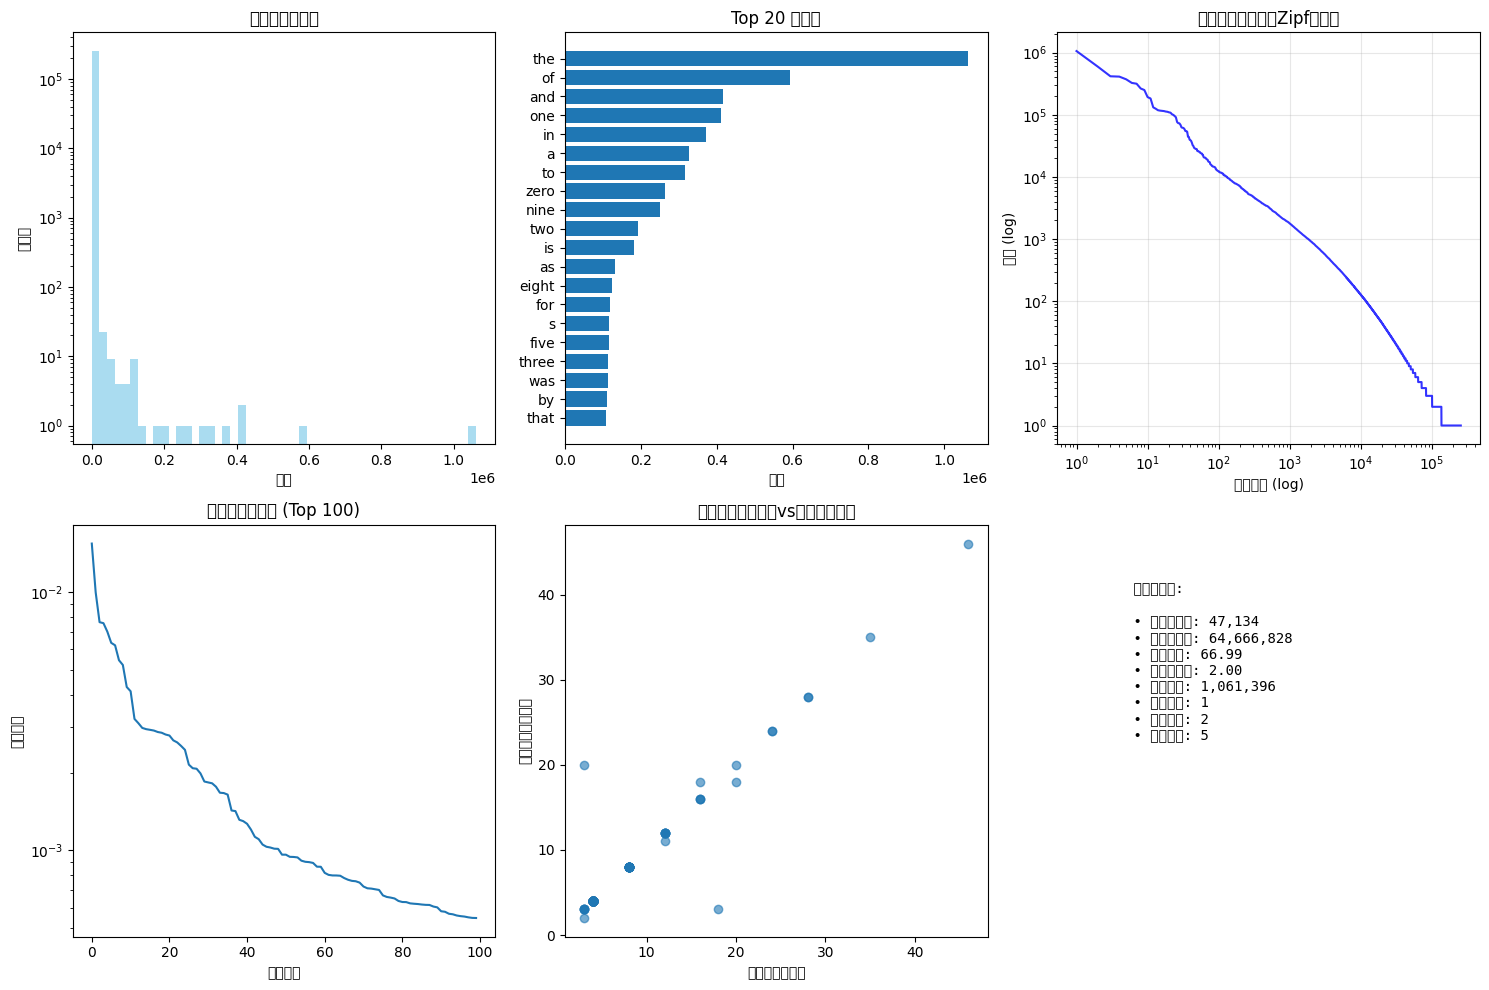

In [3]:
# Skip-gram数据集类
class SkipGramDataset:
    def __init__(self, text, word_to_idx, window_size=2):
        self.text = text
        self.word_to_idx = word_to_idx
        self.window_size = window_size
        self.data = self._create_training_data()

    def _create_training_data(self):
        """创建训练数据对"""
        words = self.text.split()
        data = []

        for i, target_word in enumerate(words):
            if target_word not in self.word_to_idx:
                continue

            target_idx = self.word_to_idx[target_word]

            # 获取窗口内的上下文词
            start = max(0, i - self.window_size)
            end = min(len(words), i + self.window_size + 1)

            for j in range(start, end):
                if j != i and words[j] in self.word_to_idx:
                    context_idx = self.word_to_idx[words[j]]
                    data.append((target_idx, context_idx))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Negative Sampling类


class NegativeSampler:
    def __init__(self, word_frequencies, negative_samples=5):
        self.negative_samples = negative_samples
        # 使用3/4次幂进行采样概率调整（Mikolov et al.的方法）
        self.sampling_probs = np.power(word_frequencies, 0.75)
        self.sampling_probs = self.sampling_probs / np.sum(self.sampling_probs)
        self.vocab_size = len(word_frequencies)

    def sample_negatives(self, positive_word):
        """采样负样本"""
        negative_samples = []
        while len(negative_samples) < self.negative_samples:
            neg_word = np.random.choice(self.vocab_size, p=self.sampling_probs)
            if neg_word != positive_word:
                negative_samples.append(neg_word)
        return negative_samples


# 创建数据集
dataset = SkipGramDataset(processed_text, preprocessor.word_to_idx, window_size=2)
print(f"训练数据对数量: {len(dataset)}")

# 创建negative sampler
word_frequencies = preprocessor.get_word_frequencies()
neg_sampler = NegativeSampler(word_frequencies, negative_samples=5)

# 数据分析和可视化


def analyze_data():
    """分析数据分布"""
    # 词频分析
    freq_values = list(preprocessor.word_freq.values())

    plt.figure(figsize=(15, 10))

    # 词频分布直方图
    plt.subplot(2, 3, 1)
    plt.hist(freq_values, bins=50, alpha=0.7, color='skyblue')
    plt.xlabel('词频')
    plt.ylabel('词数量')
    plt.title('词频分布直方图')
    plt.yscale('log')

    # Top 20高频词
    plt.subplot(2, 3, 2)
    top_words = dict(preprocessor.word_freq.most_common(20))
    plt.barh(list(top_words.keys()), list(top_words.values()))
    plt.xlabel('频次')
    plt.title('Top 20 高频词')
    plt.gca().invert_yaxis()

    # 词频的幂律分布（Zipf定律）
    plt.subplot(2, 3, 3)
    sorted_freqs = sorted(freq_values, reverse=True)
    ranks = np.arange(1, len(sorted_freqs) + 1)
    plt.loglog(ranks, sorted_freqs, 'b-', alpha=0.8)
    plt.xlabel('词频排名 (log)')
    plt.ylabel('词频 (log)')
    plt.title('词频的幂律分布（Zipf定律）')
    plt.grid(True, alpha=0.3)

    # 负采样概率分布
    plt.subplot(2, 3, 4)
    sampling_probs_sorted = np.sort(neg_sampler.sampling_probs)[::-1]
    plt.plot(sampling_probs_sorted[:100])  # 只显示前100个
    plt.xlabel('词汇索引')
    plt.ylabel('采样概率')
    plt.title('负采样概率分布 (Top 100)')
    plt.yscale('log')

    # 训练数据示例
    plt.subplot(2, 3, 5)
    sample_data = dataset.data[:1000]  # 取前1000个数据点
    target_words, context_words = zip(*sample_data)
    target_counts = Counter(target_words)
    context_counts = Counter(context_words)

    plt.scatter(list(target_counts.values()), list(context_counts.values()), alpha=0.6)
    plt.xlabel('目标词出现次数')
    plt.ylabel('上下文词出现次数')
    plt.title('训练数据中目标词vs上下文词分布')

    # 数据统计摘要
    plt.subplot(2, 3, 6)
    plt.axis('off')
    stats_text = f"""
    数据集统计:
    
    • 词汇表大小: {len(preprocessor.word_to_idx):,}
    • 训练数据对: {len(dataset):,}
    • 平均词频: {np.mean(freq_values):.2f}
    • 词频中位数: {np.median(freq_values):.2f}
    • 最高词频: {max(freq_values):,}
    • 最低词频: {min(freq_values):,}
    • 窗口大小: {dataset.window_size}
    • 负样本数: {neg_sampler.negative_samples}
    """
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=10, fontfamily='monospace')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, 'data_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()


# 执行数据分析
analyze_data()

In [4]:
# Skip-gram模型（带负采样）
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # 输入嵌入层（目标词）
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 输出嵌入层（上下文词）
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        """初始化嵌入层权重"""
        # 使用均匀分布初始化
        init_range = 0.5 / self.embedding_dim
        self.in_embeddings.weight.data.uniform_(-init_range, init_range)
        self.out_embeddings.weight.data.uniform_(-init_range, init_range)

    def forward(self, target_word, context_word, negative_samples):
        """
        前向传播
        target_word: (batch_size,) 目标词索引
        context_word: (batch_size,) 正样本上下文词索引  
        negative_samples: (batch_size, neg_samples) 负样本索引
        """
        batch_size = target_word.size(0)
        neg_samples = negative_samples.size(1)

        # 获取目标词嵌入
        target_embed = self.in_embeddings(target_word)  # (batch_size, embed_dim)

        # 正样本得分
        pos_embed = self.out_embeddings(context_word)  # (batch_size, embed_dim)
        pos_score = torch.sum(target_embed * pos_embed, dim=1)  # (batch_size,)
        pos_loss = -torch.log(torch.sigmoid(pos_score))  # (batch_size,)

        # 负样本得分
        neg_embed = self.out_embeddings(negative_samples)  # (batch_size, neg_samples, embed_dim)
        # 扩展target_embed维度以进行批量计算
        target_embed_expanded = target_embed.unsqueeze(1).expand(-1, neg_samples, -1)  # (batch_size, neg_samples, embed_dim)
        neg_scores = torch.sum(target_embed_expanded * neg_embed, dim=2)  # (batch_size, neg_samples)
        neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_scores)), dim=1)  # (batch_size,)

        # 总损失
        total_loss = pos_loss + neg_loss  # (batch_size,)
        return total_loss.mean()

    def get_word_embeddings(self):
        """获取训练好的词嵌入"""
        return self.in_embeddings.weight.data

    def similarity(self, word_idx1, word_idx2):
        """计算两个词的余弦相似度"""
        embed1 = self.in_embeddings.weight[word_idx1]
        embed2 = self.in_embeddings.weight[word_idx2]

        cos_sim = torch.cosine_similarity(embed1.unsqueeze(0), embed2.unsqueeze(0))
        return cos_sim.item()

    def most_similar(self, word_idx, top_k=10):
        """找到与给定词最相似的词"""
        word_embed = self.in_embeddings.weight[word_idx].unsqueeze(0)
        all_embeds = self.in_embeddings.weight

        # 计算余弦相似度
        similarities = torch.cosine_similarity(word_embed, all_embeds)

        # 获取top-k相似词（排除自身）
        similarities[word_idx] = -1  # 排除自身
        top_indices = torch.topk(similarities, top_k).indices

        return top_indices.tolist(), similarities[top_indices].tolist()

# 训练数据加载器


class SkipGramDataLoader:
    def __init__(self, dataset, negative_sampler, batch_size=512):
        self.dataset = dataset
        self.negative_sampler = negative_sampler
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))

    def shuffle(self):
        """打乱数据顺序"""
        random.shuffle(self.indices)

    def __iter__(self):
        """迭代器，返回批次数据"""
        for i in range(0, len(self.indices), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]

            targets = []
            contexts = []
            negatives = []

            for idx in batch_indices:
                target, context = self.dataset[idx]
                neg_samples = self.negative_sampler.sample_negatives(context)

                targets.append(target)
                contexts.append(context)
                negatives.append(neg_samples)

            # 转换为tensor
            targets = torch.tensor(targets, dtype=torch.long, device=device)
            contexts = torch.tensor(contexts, dtype=torch.long, device=device)
            negatives = torch.tensor(negatives, dtype=torch.long, device=device)

            yield targets, contexts, negatives

    def __len__(self):
        """返回批次数量"""
        return (len(self.indices) + self.batch_size - 1) // self.batch_size


# 初始化模型
vocab_size = len(preprocessor.word_to_idx)
embedding_dim = 100
model = SkipGramNegSampling(vocab_size, embedding_dim).to(device)

# 创建数据加载器
batch_size = 512
data_loader = SkipGramDataLoader(dataset, neg_sampler, batch_size)

print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"批次大小: {batch_size}")
print(f"每个epoch的批次数: {len(data_loader)}")

模型参数数量: 9,426,800
批次大小: 512
每个epoch的批次数: 126303


In [5]:
# 训练函数
def train_model(model, data_loader, epochs=10, lr=0.001):
    """训练skip-gram模型"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    # 记录训练过程
    train_losses = []
    epoch_losses = []

    print("开始训练...")
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0

        # 每个epoch打乱数据
        data_loader.shuffle()

        # 使用tqdm显示进度条
        pbar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for targets, contexts, negatives in pbar:
            # 前向传播
            loss = model(targets, contexts, negatives)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 记录损失
            batch_loss = loss.item()
            train_losses.append(batch_loss)
            epoch_loss += batch_loss
            batch_count += 1

            # 更新进度条
            pbar.set_postfix({'Loss': f'{batch_loss:.4f}'})

        avg_epoch_loss = epoch_loss / batch_count
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}')

        # 每5个epoch保存一次模型
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(),
                       os.path.join(MODEL_DIR, f'skipgram_epoch_{epoch+1}.pth'))

    # 保存最终模型
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'skipgram_final.pth'))

    return train_losses, epoch_losses


# 训练模型
epochs = 15
learning_rate = 0.001

print(f"训练配置:")
print(f"- 词汇表大小: {vocab_size}")
print(f"- 嵌入维度: {embedding_dim}")
print(f"- 批次大小: {batch_size}")
print(f"- 训练轮数: {epochs}")
print(f"- 学习率: {learning_rate}")
print(f"- 负样本数: {neg_sampler.negative_samples}")
print(f"- 设备: {device}")
print()

train_losses, epoch_losses = train_model(model, data_loader, epochs, learning_rate)

# 可视化训练过程


def plot_training_curves(train_losses, epoch_losses):
    """绘制训练过程曲线"""
    plt.figure(figsize=(15, 5))

    # 批次损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, alpha=0.7, color='blue')
    plt.title('Batch Loss Curve')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # 平滑处理的批次损失
    plt.subplot(1, 3, 2)
    window_size = len(train_losses) // 100  # 取1%的窗口
    if window_size > 1:
        smoothed_losses = []
        for i in range(len(train_losses)):
            start_idx = max(0, i - window_size)
            end_idx = min(len(train_losses), i + window_size + 1)
            smoothed_losses.append(np.mean(train_losses[start_idx:end_idx]))
        plt.plot(smoothed_losses, color='red', linewidth=2)
    else:
        plt.plot(train_losses, color='red', linewidth=2)
    plt.title('Smoothed Batch Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # Epoch损失曲线
    plt.subplot(1, 3, 3)
    plt.plot(epoch_losses, 'o-', color='green', linewidth=2, markersize=6)
    plt.title('Epoch Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True, alpha=0.3)

    for i, loss in enumerate(epoch_losses):
        plt.annotate(f'{loss:.3f}', (i, loss), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()


# 绘制训练曲线
plot_training_curves(train_losses, epoch_losses)

print("训练完成！")

训练配置:
- 词汇表大小: 47134
- 嵌入维度: 100
- 批次大小: 512
- 训练轮数: 15
- 学习率: 0.001
- 负样本数: 5
- 设备: mps

开始训练...


Epoch 1/15:   0%|          | 49/126303 [00:29<20:56:00,  1.68it/s, Loss=4.1439]


KeyboardInterrupt: 

In [ ]:
# 模型测试和评估
model.eval()


def test_word_similarities():
    """测试词相似度"""
    # 选择一些测试词
    test_words = ['the', 'and', 'of', 'to', 'a', 'in', 'is', 'it', 'you', 'that']

    # 过滤出存在于词汇表中的词
    valid_test_words = [word for word in test_words if word in preprocessor.word_to_idx]

    if not valid_test_words:
        # 如果测试词不存在，选择词汇表中的高频词
        valid_test_words = list(preprocessor.word_freq.most_common(10))
        valid_test_words = [word for word, count in valid_test_words]

    print("词相似度测试:")
    print("=" * 50)

    results = {}
    for word in valid_test_words[:5]:  # 测试前5个词
        if word in preprocessor.word_to_idx:
            word_idx = preprocessor.word_to_idx[word]
            similar_indices, similarities = model.most_similar(word_idx, top_k=5)

            similar_words = []
            for idx, sim in zip(similar_indices, similarities):
                similar_word = preprocessor.idx_to_word[idx]
                similar_words.append((similar_word, sim))

            results[word] = similar_words

            print(f"\n'{word}' 的最相似词:")
            for similar_word, similarity in similar_words:
                print(f"  {similar_word}: {similarity:.4f}")

    return results

# 词嵌入可视化


def visualize_embeddings(num_words=100):
    """使用t-SNE可视化词嵌入"""
    print("正在生成词嵌入可视化...")

    # 获取词嵌入
    embeddings = model.get_word_embeddings().cpu().numpy()

    # 选择高频词进行可视化
    top_words = dict(preprocessor.word_freq.most_common(num_words))
    word_indices = [preprocessor.word_to_idx[word] for word in top_words.keys()
                    if word in preprocessor.word_to_idx]

    if len(word_indices) < 10:
        print("词汇量太少，无法进行有效可视化")
        return

    # 选择对应的嵌入
    selected_embeddings = embeddings[word_indices]
    selected_words = [preprocessor.idx_to_word[idx] for idx in word_indices]

    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(word_indices)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # 可视化
    plt.figure(figsize=(15, 12))

    # 绘制散点图
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=50)

    # 添加词标签
    for i, word in enumerate(selected_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.8)